# TM10007 Assignment lipomas G9

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Machine-Learning-TM10007-G9/Lipo-MRI.git

  Preparing metadata (setup.py) ... done


# **Data loading**



In [2]:
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


# **Import important functions**

In [3]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from collections import Counter

# **Create X and Y**

In [4]:
X = data.iloc[:, 1:].values
y = np.array(data['label'])

# Assuming y is a list of strings representing class labels
class_counts = Counter(y)

# Display class counts
for class_label, count in class_counts.items():
    print(f"Class '{class_label}': {count} samples")

# **Split the data**

In [5]:
# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=0)

#print(len(X_train))
#print(len(X_test))
#print(len(y_train))
#print(len(y_test))

# **Check for missing values**



In [6]:
missing_values = np.sum(np.isnan(X_train))

print("Number of missing values:",missing_values)

Number of missing values: 0


# **Checks if all the data points are floats**

In [7]:
non_floats = 0
for row in X_train:
  for col in row:
    if not isinstance(col, float):
        non_floats += 1

if non_floats == 0:
  print("All values in the dataset are floats")
else:
  print(f"{non_floats} values in dataset are not floats")

All values in the dataset are floats


# **Check for duplicates**

In [8]:
# Function to find duplicate columns and delete them
def delete_duplicate_columns(arr):
    num_cols = arr.shape[1]
    duplicate_columns = []
    for i in range(num_cols):
        for j in range(i + 1, num_cols):
            if np.array_equal(arr[:, i], arr[:, j]):
                duplicate_columns.append(j)  # Append index of the duplicate column
    if duplicate_columns:
        # Delete duplicate columns
        arr_without_duplicates = np.delete(arr, duplicate_columns, axis=1)
        return arr_without_duplicates
    else:
        return arr

# Remove duplicate columns
X_train_clean = delete_duplicate_columns(X_train)

print("Number of columns in original array:",X_train.shape[1])
print("Number of columns after removal of duplicate columns:",X_train_clean.shape[1])

Number of columns in original array: 493
Number of columns after removal of duplicate columns: 465


# **Checking for outliers**
Using the Z-score

In [9]:
num_rows, num_cols = X_train_clean.shape
total_outliers = 0

for i in range(num_cols):
    z = np.abs(stats.zscore(X_train_clean[:,i]))

    threshold = 3
    outliers = X_train_clean[z > threshold, i]
    total_outliers +=(len(outliers))

print(f'Total number of outliers  = {total_outliers}/{num_rows*num_cols}')
print(f'Avarage number of outliers per feature = {round(total_outliers/num_cols,2)}/{num_rows}')


Total number of outliers  = 661/42780
Avarage number of outliers per feature = 1.42/92


# **Check if the data is normally distributed**
Using the Kolmogorov Smirnov

In [10]:
total_not_normal = 0
p_threshold = 0.05

for l in range(num_cols):
    kstest_result = stats.kstest(X_train_clean[:,l], 'norm')
    if kstest_result.pvalue < p_threshold:
        total_not_normal += 1

print(f'Total features that are not normally distributed = {total_not_normal}/{num_cols}')


Total features that are not normally distributed = 464/465


# **Scaling**
Robust scaling because outliers and non Gaussian distribution

In [11]:
# Scale the data to be normal
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_clean)
X_train_scaled = scaler.transform(X_train_clean)

# **Finding important features**

Feature ranking:


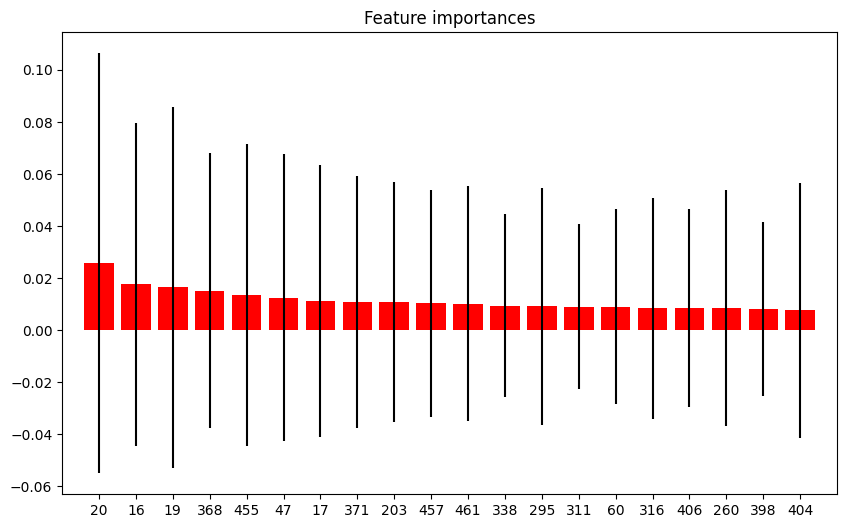

In [44]:
forest = RandomForestClassifier(n_estimators=100)

forest.fit(X_train_scaled, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(X_train_scaled.shape[1]):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest for the first 35 features
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.title("Feature importances")
plt.bar(range(20), importances[indices][:20],
       color="r", yerr=std[indices][:20], align="center")
plt.xticks(range(20), indices[:20])
plt.xlim([-1, 20])
plt.show()

# **Feature selection**
Using L1 because it can better handle high dimensionality, it migigates overfitting and is easy to interpret

In [58]:
print("Original data shape:",X_train_scaled.shape)
clf = LogisticRegression(max_iter=1000, solver='liblinear')
lsvc = LogisticRegression(C=0.5, penalty="l1", dual=False, solver='liblinear').fit(X_train_scaled, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_feature = model.transform(X_train_scaled)
print("New data shape:",X_feature.shape)

Original data shape: (92, 465)
New data shape: (92, 37)


# **PCA**

In [13]:
# Voer PCA uit
pca = decomposition.PCA(n_components=10)  #n_components is the amount of features that remain after PCA (can also be a ratio)
X_pca = pca.fit_transform(X_feature)

# Verklaarde variantie ratio's
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulatieve verklaarde variantie
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Maak een DataFrame om de resultaten mooi weer te geven
df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': cumulative_explained_variance
})

print(df)

  Principal Component  Explained Variance Ratio  Cumulative Explained Variance
0                 PC1                  0.959157                       0.959157
1                 PC2                  0.026176                       0.985333
2                 PC3                  0.007162                       0.992495
3                 PC4                  0.004295                       0.996790
4                 PC5                  0.002573                       0.999364
5                 PC6                  0.000305                       0.999668
6                 PC7                  0.000203                       0.999871
7                 PC8                  0.000058                       0.999929
8                 PC9                  0.000041                       0.999970
9                PC10                  0.000018                       0.999988


# **Random forest**

In [59]:
# Initialize KFold cross-validator
loo = LeaveOneOut()

scores_rfc = []
# Iterate over each fold
for train_index, val_index in loo.split(X_feature, y_train):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_feature[train_index], X_feature[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train_fold,y_train_fold)
    pred_rfc = rfc.predict(X_val_fold)
    accuracy_rfc = accuracy_score(y_val_fold, pred_rfc)

    # Append accuracy to scores list
    scores_rfc.append(accuracy_rfc)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores_rfc)

# Calculate and print the average accuracy across all folds
average_accuracy_rfc = sum(scores_rfc) / len(scores_rfc)
print("Average Accuracy:", average_accuracy_rfc)

Accuracy scores for each fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average Accuracy: 0.7934782608695652


In [60]:
loo = LeaveOneOut()

# Define the parameter grid for grid search
param_grid = {'n_estimators': range(50, 200, 10)}  # Adjust the range as needed

# Initialize Random Forest classifier
rfc = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=loo, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(X_feature, y_train)

# Get the best estimator from grid search
best_rfc = grid_search.best_estimator_

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Get the best score from grid search
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'n_estimators': 130}
Best Score: 0.8260869565217391


# **SVM**

In [62]:
# Initialize KFold cross-validator
loo = LeaveOneOut()

scores_clf = []
# Iterate over each fold
for train_index, val_index in loo.split(X_feature, y_train):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_feature[train_index], X_feature[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    clf = svm.SVC()
    clf.fit(X_train_fold,y_train_fold)
    pred_clf = clf.predict(X_val_fold)
    accuracy_clf = accuracy_score(y_val_fold, pred_clf)

    # Append accuracy to scores list
    scores_clf.append(accuracy_clf)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores_clf)

# Calculate and print the average accuracy across all folds
average_accuracy_clf = sum(scores_clf) / len(scores_clf)
print("Average Accuracy:", average_accuracy_clf)

Accuracy scores for each fold: [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
Average Accuracy: 0.5434782608695652


In [61]:
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],                      # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],    # Kernel type
}

# Initialize SVM classifier
svc = svm.SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=loo, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(X_feature, y_train)

# Get the best estimator from grid search
best_svc = grid_search.best_estimator_

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Get the best score from grid search
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Score: 0.7934782608695652


# **Neural network**

In [63]:
# Initialize KFold cross-validator
loo = LeaveOneOut()

scores_mlpc = []
# Iterate over each fold
for train_index, val_index in loo.split(X_feature, y_train):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_feature[train_index], X_feature[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    mlpc = MLPClassifier(hidden_layer_sizes=(50,50),max_iter=500, random_state=42)
    mlpc.fit(X_train_fold, y_train_fold)
    pred_mlpc = mlpc.predict(X_val_fold)
    accuracy_mlpc = accuracy_score(y_val_fold, pred_mlpc)

    # Append accuracy to scores list
    scores_mlpc.append(accuracy_mlpc)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores_mlpc)

# Calculate and print the average accuracy across all folds
average_accuracy_mlpc = sum(scores_mlpc) / len(scores_mlpc)
print("Average Accuracy:", average_accuracy_mlpc)

Accuracy scores for each fold: [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
Average Accuracy: 0.6847826086956522


In [65]:
# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Number of neurons in each hidden layer
    'activation': ['relu', 'tanh', 'logistic'],        # Activation function
    'learning_rate': ['constant', 'adaptive'],      # Learning rate schedule
    'early_stopping': [True]
}

# Initialize MLPClassifier
mlp = MLPClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=loo, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(X_feature, y_train)

# Get the best estimator from grid search
best_mlp = grid_search.best_estimator_

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Get the best score from grid search
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Best Score: 0.6739130434782609
